# Project Challenge Assignment
Nama : Heriswaya<br>
Tempat Magang : Yayasan Bintang Langit

In [1]:
# Cell 1: Install dependencies (jalankan sekali)
# Saya memasang library yang diperlukan. Jika sudah ada beberapa, pip akan mengabaikannya.
!pip install -q sentence-transformers scikit-learn bertopic hdbscan umap-learn matplotlib pandas tqdm joblib nltk
# Note: bertopic akan menginstal banyak dependensi; jalankan ini di awal.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.6 MB/s eta 0:00:00


In [2]:
# Cell 2: Imports & config dasar
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# sentence-transformers
from sentence_transformers import SentenceTransformer

# BERTopic
from bertopic import BERTopic

# plotting
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Saya set display supaya tabel tidak terpotong
pd.set_option('display.max_colwidth', 300)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [3]:
# Cell 3: Helper functions kecil
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

def simple_clean(text):
    # Saya lakukan pembersihan dasar: remove extra spaces & non-printable
    text = str(text)
    text = text.replace('\n',' ').replace('\r',' ')
    text = re.sub(r'\s+',' ', text).strip()
    return text

# Fungsi untuk membaca file .txt yang berisi Python literal (list atau list of tuples)
import ast
def read_python_literal_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        txt = f.read()
    return ast.literal_eval(txt)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Cell 4: Load data (coba beberapa path, fallback to upload)
# Saya coba load dari beberapa lokasi; jika tidak ada, muncul dialog upload.
label_paths = [
    "/mnt/data/data labeling history sentimen.txt",
    "/content/data labeling history sentimen.txt",
    "data labeling history sentimen.txt"
]
nonlabel_paths = [
    "/mnt/data/data non label ecommerce.txt",
    "/content/data non label ecommerce.txt",
    "data non label ecommerce.txt"
]

label_path = None
nonlabel_path = None

for p in label_paths:
    if os.path.exists(p):
        label_path = p
        break

for p in nonlabel_paths:
    if os.path.exists(p):
        nonlabel_path = p
        break

# Jika belum ditemukan, minta upload file (Colab)
if label_path is None or nonlabel_path is None:
    print("Beberapa file belum ditemukan di path standar. Silakan upload file lewat dialog (atau mount Drive).")
    from google.colab import files
    uploaded = files.upload()
    # Simpan uploaded files ke /content dengan nama aslinya
    for fn in uploaded:
        open(fn, 'wb').write(uploaded[fn])
    # Atur path ke file yang diupload (cocokkan nama)
    for p in label_paths:
        if os.path.exists(p):
            label_path = p
            break
    if label_path is None:
        for fn in uploaded:
            if "label" in fn.lower() or "sentimen" in fn.lower():
                label_path = fn
                break
    for p in nonlabel_paths:
        if os.path.exists(p):
            nonlabel_path = p
            break
    if nonlabel_path is None:
        for fn in uploaded:
            if "non" in fn.lower() or "ecom" in fn.lower() or "ecom" in fn.lower():
                nonlabel_path = fn
                break

print("Labeled file:", label_path)
print("Non-labeled file:", nonlabel_path)

Labeled file: /content/data labeling history sentimen.txt
Non-labeled file: /content/data non label ecommerce.txt


In [5]:
# Cell 5: Parse & create DataFrame
# Saya asumsikan file labeled berformat list of tuples [(text,label), ...] atau list of dicts.
# Jika berbeda, silakan sesuaikan sedikit.
assert label_path is not None, "File labeled tidak ditemukan. Harap upload/letakkan file."
assert nonlabel_path is not None, "File non-label tidak ditemukan. Harap upload/letakkan file."

# Load labeled
try:
    raw_label = read_python_literal_file(label_path)
    # Deteksi format
    if isinstance(raw_label, list) and len(raw_label)>0 and isinstance(raw_label[0], (list, tuple)):
        df_label = pd.DataFrame(raw_label, columns=['text','label'])
    elif isinstance(raw_label, list) and len(raw_label)>0 and isinstance(raw_label[0], dict):
        df_label = pd.DataFrame(raw_label)
        if 'text' not in df_label.columns:
            # coba kolom lain
            cols = df_label.columns.tolist()
            df_label = df_label.rename(columns={cols[0]:'text', cols[1]:'label'})
    else:
        raise ValueError("Format labeled tidak dikenali.")
except Exception as e:
    # fallback: coba baca csv/simple lines
    print("Gagal parse labeled sebagai Python literal:", e)
    try:
        df_label = pd.read_csv(label_path, sep=None, engine='python')
    except:
        lines = open(label_path,'r',encoding='utf-8').read().splitlines()
        # asumsi "text \t label"
        parsed = [l.split('\t') for l in lines if l.strip()]
        df_label = pd.DataFrame(parsed, columns=['text','label'])

# Load non-labeled (as list of strings)
try:
    raw_non = read_python_literal_file(nonlabel_path)
    if isinstance(raw_non, list):
        docs = [simple_clean(t) for t in raw_non]
    else:
        raise ValueError("Format non-label unexpected.")
except Exception as e:
    print("Gagal parse non-label sebagai Python literal:", e)
    try:
        docs = [simple_clean(l) for l in open(nonlabel_path,'r',encoding='utf-8').read().splitlines() if l.strip()]
    except Exception as ee:
        raise ee

# Clean labeled
df_label['text'] = df_label['text'].apply(simple_clean)
df_label['label'] = df_label['label'].astype(str).str.strip()
df_label = df_label[df_label['text'].str.len()>0].reset_index(drop=True)

print("Labeled shape:", df_label.shape)
print("Non-labeled docs:", len(docs))
display(df_label.sample(5))

Labeled shape: (49, 2)
Non-labeled docs: 60


,text,label
13,Karyawan cuek dan tidak membantu,negative
45,Aplikasi sangat berguna dan efisien,positive
47,Rasanya lezat dan pelayanan luar biasa,positive
44,Sistem pembayaran sering error,negative
17,"Sangat mengecewakan, tidak akan beli lagi",negative


In [7]:
# Cell 6: Quick EDA pada data labeled
# Saya cek distribusi kelas dan beberapa kata paling sering.
print("Distribusi label:")
print(df_label['label'].value_counts())

# Top tokens (very simple)
from collections import Counter
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
stop_ind = set(stopwords.words('indonesian')) if 'indonesian' in stopwords.fileids() else set()
def top_tokens(texts, n=20):
    cnt = Counter()
    for t in texts:
        toks = [w.lower() for w in word_tokenize(t) if w.isalpha()]
        toks = [w for w in toks if w not in stop_ind]
        cnt.update(toks)
    return cnt.most_common(n)

print("Top tokens (labeled):", top_tokens(df_label['text'].tolist(), 25))

Distribusi label:
label
positive    25
negative    24
Name: count, dtype: int64


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Top tokens (labeled): [('pelayanan', 7), ('cepat', 6), ('kualitas', 5), ('harga', 4), ('puas', 4), ('layanan', 4), ('sesuai', 4), ('enak', 3), ('restoran', 3), ('aplikasi', 3), ('produk', 3), ('pelayanannya', 3), ('makanan', 3), ('membantu', 3), ('buruk', 3), ('ramah', 2), ('makanannya', 2), ('tempatnya', 2), ('nyaman', 2), ('bagus', 2), ('pengiriman', 2), ('direkomendasikan', 2), ('keluarga', 2), ('pelanggan', 2), ('pesanan', 2)]


In [8]:
# Cell 7: Prepare supervised pipeline - Train/Test split + embeddings
# Saya gunakan embedding ringan 'all-MiniLM-L6-v2' untuk efisiensi.
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

X = df_label['text'].tolist()
y = df_label['label'].tolist()

# Stratified split karena kemungkinan imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print("Train / Test sizes:", len(X_train), "/", len(X_test))

# Encode (embedding) — tunjukkan progress bar
X_train_emb = embedder.encode(X_train, show_progress_bar=True)
X_test_emb = embedder.encode(X_test, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Train / Test sizes: 39 / 10


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Cell 8: Train simple classifier (Logistic Regression)
# Saya pilih LR sebagai baseline: stabil & cepat.
clf = LogisticRegression(max_iter=2000, random_state=SEED)
clf.fit(X_train_emb, y_train)

# Evaluate
y_pred = clf.predict(X_test_emb)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7

Classification report:
               precision    recall  f1-score   support

    negative     0.7500    0.6000    0.6667         5
    positive     0.6667    0.8000    0.7273         5

    accuracy                         0.7000        10
   macro avg     0.7083    0.7000    0.6970        10
weighted avg     0.7083    0.7000    0.6970        10

Confusion matrix:
 [[3 2]
 [1 4]]


In [10]:
# Cell 9: Simpan model & embedder (opsional)
joblib.dump(clf, "sentiment_clf_lr.joblib")
# SentenceTransformer memiliki method save
embedder.save("sentence_transformer_all_minilm_l6_v2")
print("Models saved: sentiment_clf_lr.joblib & sentence_transformer_all_minilm_l6_v2/")

Models saved: sentiment_clf_lr.joblib & sentence_transformer_all_minilm_l6_v2/


In [11]:
# Cell 10: Topic modeling (BERTopic) pada data non-label
# Saya pakai BERTopic dengan embedding model yang sama untuk konsistensi.
# Untuk dataset besar, proses ini bisa butuh waktu dan RAM.
topic_model = BERTopic(embedding_model=model_name, calculate_probabilities=True, verbose=False, seed_topic_list=None)
topics, probs = topic_model.fit_transform(docs)

# Info topik
info = topic_model.get_topic_info()
display(info.head(20))

,Topic,Count,Name,Representation,Representative_Docs
0,-1,23,-1_dan_cepat_packing_aman,"[dan, cepat, packing, aman, barang, dikirim, rapi, checkout, tiba, di]","[Packing cepat dan dikirim hari yang sama., Barang dikirim dengan packing rapi, aman., Packing sangat rapi dan aman, bubble wrap tebal.]"
1,0,21,0_tidak_harga_tapi_kualitas,"[tidak, harga, tapi, kualitas, sesuai, sekali, sama, banget, kardus, palsu]","[Kualitas oke tapi tidak seperti ekspektasi., Harga wajar dan sesuai kualitas., Kualitas bahan tipis, tidak sesuai harga.]"
2,1,16,1_dan_produk_pengiriman_sangat,"[dan, produk, pengiriman, sangat, banget, cepat, datang, baik, belanja, baru]","[Pengiriman cepat banget, dua hari langsung sampai., Barang bagus banget, sesuai deskripsi dan berfungsi dengan baik., Produk cacat tapi respon penjual cepat dan diganti baru.]"


In [12]:
# Cell 11: Inspect top terms tiap topik (tambah label manual jika perlu)
# Saya tampilkan top 10 topik teratas dan kata-katanya
top_n = 10
top_topics = info[info.Topic != -1].head(top_n)['Topic'].tolist()
for t in top_topics:
    print(f"\n--- Topic {t} (top terms) ---")
    print(topic_model.get_topic(t))


--- Topic 0 (top terms) ---
[('tidak', np.float64(0.1809179577653008)), ('harga', np.float64(0.16851947603596729)), ('tapi', np.float64(0.11234631735731153)), ('kualitas', np.float64(0.11091503071845671)), ('sesuai', np.float64(0.10564358897593731)), ('sekali', np.float64(0.09995735376235343)), ('sama', np.float64(0.07496801532176507)), ('banget', np.float64(0.06066707021313492)), ('kardus', np.float64(0.059727192890628)), ('palsu', np.float64(0.059727192890628))]

--- Topic 1 (top terms) ---
[('dan', np.float64(0.14222853045633527)), ('produk', np.float64(0.11039464633092669)), ('pengiriman', np.float64(0.10216229538946417)), ('sangat', np.float64(0.0958263687653377)), ('banget', np.float64(0.08267375254535053)), ('cepat', np.float64(0.08267375254535053)), ('datang', np.float64(0.08139293933134599)), ('baik', np.float64(0.08139293933134599)), ('belanja', np.float64(0.07359643088728446)), ('baru', np.float64(0.07359643088728446))]


In [13]:
# Cell 12: Gabungkan topic + prediksi sentimen ke DataFrame hasil
# Prediksi sentimen pada dokumen non-label
docs_emb = embedder.encode(docs, show_progress_bar=True)
pred_sent = clf.predict(docs_emb)

df_non = pd.DataFrame({'text': docs, 'topic': topics, 'sentiment': pred_sent})
# Tampilkan ringkasan distribusi
display(df_non.head(10))
print("\nDistribusi topik (count):")
print(df_non['topic'].value_counts().head(20))

# Distribusi sentimen per topik
pivot = df_non.groupby(['topic','sentiment']).size().unstack(fill_value=0)
display(pivot.head(20))

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

,text,topic,sentiment
0,"Barang bagus banget, sesuai deskripsi dan berfungsi dengan baik.",1,positive
1,"Kualitas produk jelek, cepat rusak setelah dipakai 2 hari.",1,negative
2,"Produk original dan kemasannya aman, sangat puas.",1,positive
3,Barang yang datang berbeda warna dari yang dipesan.,1,positive
4,Produk cacat tapi respon penjual cepat dan diganti baru.,1,positive
5,Barang palsu! Tidak sesuai iklan di toko.,0,negative
6,Kualitas oke tapi tidak seperti ekspektasi.,0,negative
7,"Barang ringan dan desainnya elegan, suka banget!",-1,positive
8,"Kualitas bahan tipis, tidak sesuai harga.",0,negative
9,"Barang sangat berkualitas, recommended seller!",-1,positive



Distribusi topik (count):
topic
-1    23
 0    21
 1    16
Name: count, dtype: int64


sentiment,negative,positive
topic,,
-1,3,20
0,10,11
1,5,11


In [14]:
# Cell 13: Analisis sederhana - topik dengan proporsi sentimen negatif terbesar
# Asumsikan label negatif = 'neg' or 'negative' (normalisasi dulu)
df_non['sent_norm'] = df_non['sentiment'].str.lower().map(lambda s: 'neg' if 'neg' in s else ('pos' if 'pos' in s else s))
summary = df_non.groupby('topic').sent_norm.value_counts(normalize=True).unstack(fill_value=0)
summary['total_count'] = df_non.groupby('topic').size()
# Tampilkan top 10 topik dengan proporsi 'neg' terbesar (dan cukup banyak kasus)
if 'neg' in summary.columns:
    cand = summary[summary['total_count']>=10].sort_values('neg', ascending=False).head(10)
    display(cand[['neg','total_count']])
else:
    print("Label negatif tidak ditemukan sebagai 'neg' — silakan cek format label sentimen.")

sent_norm,neg,total_count
topic,,
0,0.476190,21
1,0.312500,16
-1,0.130435,23


In [15]:
# Cell 14: Simpan hasil & export
df_non.to_csv("nonlabel_topic_sentiment.csv", index=False)
df_label.to_csv("labeled_clean.csv", index=False)
topic_model.save("bertopic_model")
print("Saved: nonlabel_topic_sentiment.csv, labeled_clean.csv, bertopic_model/")

2025-11-06 13:16:05,464 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved: nonlabel_topic_sentiment.csv, labeled_clean.csv, bertopic_model/


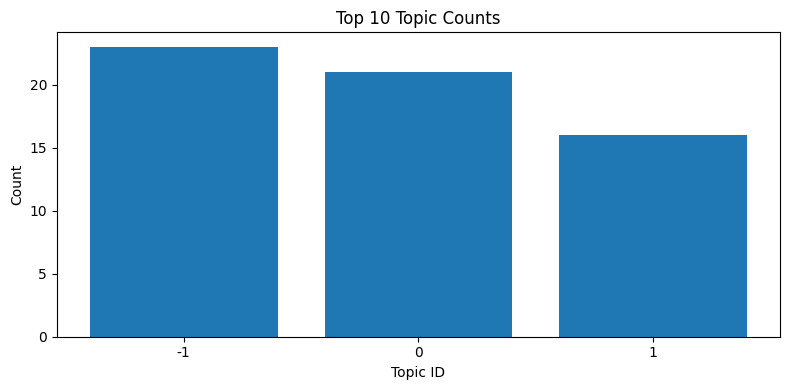

In [16]:
# Cell 15: Visualisasi sederhana (static)
# Saya buat bar chart top 10 topik berdasarkan jumlah dokumen
topic_counts = df_non['topic'].value_counts().head(10)
plt.figure(figsize=(8,4))
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.title("Top 10 Topic Counts")
plt.xlabel("Topic ID")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [17]:
# Cell 16: Ambil contoh error kasus (false predictions) untuk analisis manual
# Saya ambil beberapa contoh false negative/positive untuk inspect
mis_idx = [i for i,(y_t,y_p) in enumerate(zip(y_test, y_pred)) if y_t!=y_p]
sample_mis = min(20, len(mis_idx))
print(f"Menampilkan {sample_mis} contoh kesalahan prediksi (train/test labeled):")
for idx in mis_idx[:sample_mis]:
    print("----")
    print("Text:", X_test[idx])
    print("True:", y_test[idx], "| Pred:", y_pred[idx])

Menampilkan 3 contoh kesalahan prediksi (train/test labeled):
----
Text: Minumannya hambar dan terlalu manis
True: negative | Pred: positive
----
Text: Produk rusak saat diterima
True: negative | Pred: positive
----
Text: Aplikasinya ringan dan tidak ada bug
True: positive | Pred: negative


In [21]:
# Cell 17: Ringkasan
from textwrap import dedent
summary_text = f"""
Ringkasan Eksperimen
- Dataset labeled: {len(df_label)} baris
- Dataset non-labeled (untuk topic modeling): {len(docs)} baris
- Embedding: {model_name}
- Classifier baseline: LogisticRegression
- Metode topic modeling: BERTopic (HDBSCAN + UMAP)

File output:
- labeled_clean.csv
- nonlabel_topic_sentiment.csv
- sentiment_clf_lr.joblib
- bertopic_model/ (model BERTopic disimpan)
"""
print(dedent(summary_text))


Ringkasan Eksperimen
- Dataset labeled: 49 baris
- Dataset non-labeled (untuk topic modeling): 60 baris
- Embedding: all-MiniLM-L6-v2
- Classifier baseline: LogisticRegression
- Metode topic modeling: BERTopic (HDBSCAN + UMAP)

File output:
- labeled_clean.csv
- nonlabel_topic_sentiment.csv
- sentiment_clf_lr.joblib
- bertopic_model/ (model BERTopic disimpan)

